In [2]:
import numpy as np 
import pandas as pd 

import os
# get current notebook path
os.chdir( "/home/guido/github/spectralgradients/" )
%pwd

'/home/guido/github/spectralgradients'

In [9]:
methods = ["WSpectralGradients", "SpectralGradients", "ExpectedGradients", "IntegratedGradients", "Saliency", "InputXGrad" ]

metrics = {}

for method in methods:
    metrics[ method ] = {}
    m = np.load( f"output/metrics/{method}.npz")
    #
    metrics[ method ]["lle"] = m["lle"]
    metrics[ method ]["irof"] = m["irof"]
    metrics[ method ]["loc"] = m["loc"]

In [10]:
for method in methods:
    print(method)

    for eval_m in ["lle", "irof", "loc"]:
        print( eval_m, metrics[method][eval_m].mean(), metrics[method][eval_m].std(), len( metrics[method][eval_m]) )


WSpectralGradients
lle 0.019042214343122615 0.0008097072463573463 157
irof 0.21590561756662502 0.01288061540827274 157
loc 3.2279714960960826 0.12889970819968719 157
SpectralGradients
lle 0.5527366665518207 0.026391465230829303 157
irof 0.24976053141104948 0.014994011179896325 157
loc 2.2535815709715434 0.09713077031323157 157
ExpectedGradients
lle 0.5611672025577278 0.03507690464447056 157
irof 0.23000706390590425 0.01471037074566015 157
loc 1.5263210626164818 0.031520424706044534 157
IntegratedGradients
lle 0.6269086257667299 0.04641813323908391 157
irof 0.2502767922012669 0.012976521873967159 157
loc 2.8284131326493185 0.10051624419519144 157
Saliency
lle 0.7452444172209236 0.05441949137920544 157
irof 0.23152143209223536 0.014889740476811509 157
loc 1.2805809853183237 0.024920398568351848 157
InputXGrad
lle 0.6679516609307308 0.05984230371225676 157
irof 0.19684038610215399 0.012833510939874969 157
loc 1.6669551301154362 0.06366664010185066 157


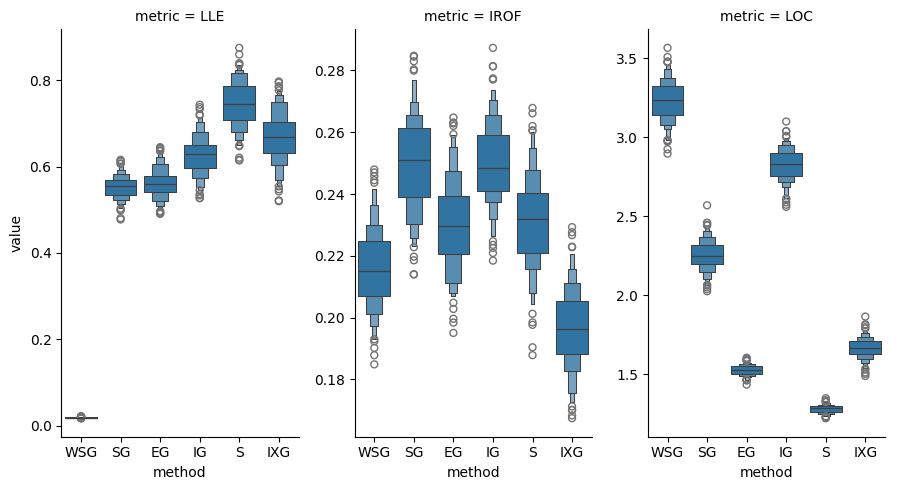

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

metrics_df = []

for method in methods:
    df = []

    for eval_m in ["lle", "irof", "loc"]:
        df_ = pd.DataFrame([])
        df_["value"] = metrics[method][eval_m]
        df_["metric"] = eval_m.upper()
        df_["method"] = method
        df.append( df_ )

    df = pd.concat( df )


    metrics_df.append( df )

metrics_df = pd.concat( metrics_df )
metrics_df["method"] = metrics_df["method"].apply( lambda x : "".join([c for c in x if c.isupper()]) )

sns.catplot(data=metrics_df, x="method", y="value", col="metric", kind="boxen", aspect=.6,sharey=False)


In [ ]:
import numpy as np
import pandas as pd
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import sys, os
from tqdm.autonotebook import tqdm

from loguru import logger

import pytorch_lightning as pl
pl.seed_everything( 1000 )

sys.path.append(os.getcwd())

######  MODEL LOADING ######


from src.train.model import TimeModule

logger.info("Loading model from checkpoint")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fn = TimeModule.load_from_checkpoint("output/model/checkpoint/epoch=19-step=21686-val_acc=0.96.ckpt").eval()
fn = nn.Sequential(OrderedDict([("fn", fn), ("softmax", nn.Softmax(dim=1))])).to(device)


##### DATA LOADING #######
from src.synt_data import SyntDataset

logger.info("Loading dataset")

batch_size = 32

data = SyntDataset()
loader = DataLoader(data, batch_size=batch_size, num_workers=8)

Seed set to 1000
2024-11-22 15:13:07.120 | INFO     | __main__:<module>:23 - Loading model from checkpoint
2024-11-22 15:13:07.163 | INFO     | __main__:<module>:33 - Loading dataset


torch.Size([50000, 1000]) torch.Size([50000])


In [16]:
from src.explainer_wrapper import explainer_wrapper, localization, lle, irof

method = {
    "method": "Saliency",
}

method["model"] = fn

method["irof"] = []
method["lle"] = []

for i in tqdm(torch.arange(0, len(data), batch_size).long()):

    if i + batch_size > len(data):
        batch_size = len(data) - 1

    x_batch, m_batch, y_batch = [], [], []

    for j in range(i, i + batch_size):

        x, m, y = data.__getitem__(j, True)

        # last class is for the baseline 
        if y == data.n_class - 1:
            continue

        x_batch += [x]
        m_batch += [m]
        y_batch += [y]


    x_batch = torch.stack(x_batch)
    m_batch = torch.stack(m_batch)
    y_batch = torch.stack(y_batch)

    method["model"] = fn

    method["inputs"] = x_batch
    method["targets"] = y_batch

    explainer, a_batch = explainer_wrapper(**method)



    logger.info( f"Evaluating {method["method"]} with IROF")
    method["irof"] += [ irof(
        explainer=explainer,
        model=fn,
        x=x_batch,
        y=y_batch,
        attr=a_batch,
        mask=m_batch,
    ) ]

    break


    logger.info( f"Evaluating {method["method"]} with LLE")
    method["lle"] += [ lle(
        explainer= explainer,
        model=fn,
        x=x_batch,
        y=y_batch,
        attr=a_batch,
        mask=m_batch,
    ).item() ]

method["irof"][-1].shape 

  0%|          | 0/1563 [00:00<?, ?it/s]


torch.Size([26, 7, 101])

In [19]:
print(method["targets"][0])
method["irof"][-1][0, 1, :]

tensor(1)


tensor([1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])

In [26]:
fn( torch.zeros_like( method["inputs"]).to(device) ).detach().cpu()[0, :] 

tensor([9.4065e-03, 7.2589e-03, 1.5997e-02, 1.4325e-02, 9.5300e-01, 4.1128e-06,
        4.5417e-06])

In [25]:
print( data.n_class  )

4


In [68]:
import torch
import torch.nn as nn
import time

# cuda clean gpu cache
import gc
gc.collect()
torch.cuda.empty_cache()

device = "cuda"

n, m = 1000, 5

f = nn.Sequential(
    nn.Linear(n, m),
    nn.Softmax(dim=-1),
).to(device)

def path_integral(
    fn: nn.Module,
    path : callable,
    jac_path: callable = None,
    n_points: int = 50,
):

    p = path(0)

    t = torch.linspace(
        0, 1, n_points, device=path(0).device, dtype=p.dtype
    )

    SG = 0
  
    for i in range(1, n_points):
        G0 = torch.func.vmap( torch.func.jacrev(fn))( path(t[i - 1])) 
        G1 = torch.func.vmap( torch.func.jacrev(fn))( path(t[i])) 

        if jac_path is None:
            Jp0 = torch.func.vmap(torch.func.jacfwd(path))( torch.ones(1, device=p.device) * t[i - 1]).squeeze() 
            Jp1 = torch.func.vmap(torch.func.jacfwd(path))( torch.ones(1, device=p.device) * t[i] ).squeeze()
        else:
            Jp0 = jac_path( t[i - 1] )
            Jp1 = jac_path( t[i] )

        Jp0, Jp1 = torch.abs(Jp0), torch.abs(Jp1)

        G0 = torch.einsum( "bmn,bn->bmn", G0, Jp0 )
        G1 = torch.einsum( "bmn,bn->bmn", G0, Jp1 )
            
        
        SG += (t[i] - t[i - 1]) * (G0 + G1) / 2
            
    return SG

def line_integral(
    fn: nn.Module,
    x_1: torch.Tensor,
    x_0: torch.Tensor,
    n_points: int = 50,
):
    def path( alpha : torch.Tensor):
        return x_1*alpha - (1-alpha)*x_0

    return path_integral( fn=fn, path = path, jac_path = None, n_points=n_points)

def fline_integral(
    fn: nn.Module,
    x_1: torch.Tensor,
    x_0: torch.Tensor,
    n_points: int = 50,
):
    def path( alpha : torch.Tensor):
        return x_1*alpha - (1-alpha)*x_0
    
    def jac_path( alpha: torch.Tensor ):
        return x_1 - x_0

    return path_integral( fn=fn, path = path, jac_path = jac_path, n_points=n_points)

x_1 = torch.ones(128, n, requires_grad=True).to(device)
x_0 = torch.zeros(128, n, requires_grad=True).to(device)
alpha = torch.tensor(0.5, requires_grad=True).to(device)

# Measure time for Jacobian calculation analytically
start_time = time.time()
jacobian0 = fline_integral(f, x_1, x_0)
end_time = time.time()

print("Jacobian of the line function with respect to alpha:")
print(jacobian0.shape)
print(f"Time taken for Jacobian calculation: {end_time - start_time:.6f} seconds")


start_time = time.time()
jacobian1 = line_integral(f, x_1, x_0)
end_time = time.time()

print("Jacobian of the line function with respect to alpha:")
print(jacobian0.shape)
print(f"Time taken for Jacobian calculation: {end_time - start_time:.6f} seconds")

print( (( jacobian0 - jacobian1)**2).reshape(-1).mean() )


Jacobian of the line function with respect to alpha:
torch.Size([128, 5, 1000])
Time taken for Jacobian calculation: 0.193800 seconds
Jacobian of the line function with respect to alpha:
torch.Size([128, 5, 1000])
Time taken for Jacobian calculation: 0.377522 seconds
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
